# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn

In [5]:
table1 = df_transactions.merge(df_offers, on='offer_id', how='inner')
pd.set_option('display.max_columns', 500)
cust_by_offer = pd.pivot_table(table1, index=['customer_name'], columns=['offer_id'], values='n', 
                               aggfunc=np.size, fill_value=0, margins=False)
cust_by_offer.head()


offer_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [6]:
# your turn

*What values of  SS  do you believe represent better clusterings? Why?*

Smaller values are better for a given, fixed K. A small SS for a given K means that points (in the aggregate using this squared metric) are closer to their cluster centers than for a model with larger SS and the same K. This aligns better with our goal to *minimize* the distance between data points and the respective centroid for the cluster they are in.

*Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)*

In [7]:
x_cols = cust_by_offer.values
x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

*Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.*

In [8]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=8)

model.fit(x_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

*Construct a plot showing  SS  for each  K  and pick  K  using this plot. For simplicity, test  2≤K≤10 .*

In [9]:
ks = range(2,11)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(x_cols)
    inertias.append(model.inertia_)

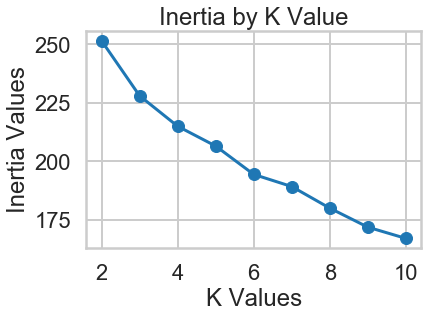

In [10]:
plt.plot(ks, inertias, 'o-')
plt.xlabel('K Values')
plt.ylabel('Inertia Values')
plt.title("Inertia by K Value")
plt.show()

In [11]:
declines = []
for i in range(1, len(inertias)):
    declines.append(inertias[i] - inertias[i-1])
declines

[-23.475282553287656,
 -12.989539515324736,
 -8.452566098775776,
 -12.096500721500718,
 -5.183874458874442,
 -9.211910366091189,
 -8.107714453533617,
 -4.801641414141443]

It's difficult to see an elbow in the plot above. Furthermore, when we look at the declines in inertia, they don't appear to be getting smaller in value by a significant amount. Therefore I will chose a value of 10 for my best K.

*Make a bar chart showing the number of points in each cluster for k-means under the best  K .*

In [12]:
model = KMeans(n_clusters=10)
model.fit(x_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [13]:
model.labels_

array([1, 3, 0, 7, 6, 6, 0, 1, 3, 1, 5, 0, 1, 5, 2, 0, 8, 0, 1, 2, 7, 3,
       3, 5, 0, 6, 2, 8, 6, 2, 2, 3, 2, 4, 1, 7, 2, 7, 5, 7, 0, 0, 3, 8,
       1, 4, 7, 2, 3, 5, 2, 6, 2, 0, 7, 1, 0, 2, 1, 3, 6, 3, 8, 1, 1, 3,
       0, 2, 6, 2, 2, 2, 2, 2, 6, 1, 2, 7, 2, 2, 2, 9, 2, 0, 1, 3, 1, 9,
       2, 3, 4, 1, 2, 1, 2, 6, 7, 6, 4, 6])

In [14]:
unique, counts = np.unique(model.labels_, return_counts=True)

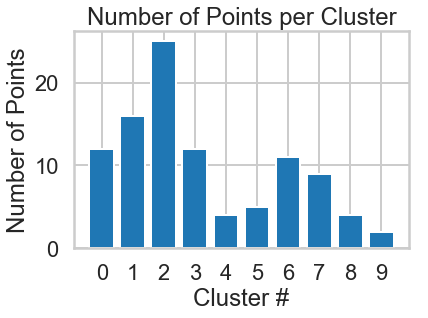

In [15]:
plt.bar(unique, counts, tick_label=unique)
plt.xlabel("Cluster #")
plt.ylabel("Number of Points")
plt.title("Number of Points per Cluster")
plt.show()

*What challenges did you experience using the Elbow method to pick  K ?*

As mentioned earlier, there is no obvious pick for K since there is no significant decline in inertia (SS) followed by much smaller declines. The biggest declines happen at the beginning from K = 2 to K = 3 and K = 3 to K = 4, which is expected, but the declines that follow are comparable, so I don't feel compelled to choose K = 3 or K = 4. Furthermore, the later decline values do not themselves decline in a decreasing manner. So for example, the decline in inertia from K = 8 to K = 9 is **smaller** than the decline in K = 9 to K = 10, which is somewhat unexpected, since I would assume that the decline in interia is decreasing with increasing K (as is the case with the elbow graphs I have seen in educational material).  

Because of these factors, I felt that K = 10 was the best choice for K, over the range of K = 2 to K = 10 for which I looked at interia and plotted their values. If I examined more values, I might choose a different K, but it is probably the case that this data does not lend itself to an obvious choice of K (since there is probably no one grouping of customers that performs far better in practice than groupings with similar numbers).

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [16]:
# Your turn.

**Exercise**: Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.

Adapted from the article linked, and altered to perform the silhouette method on our data, x_cols:

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


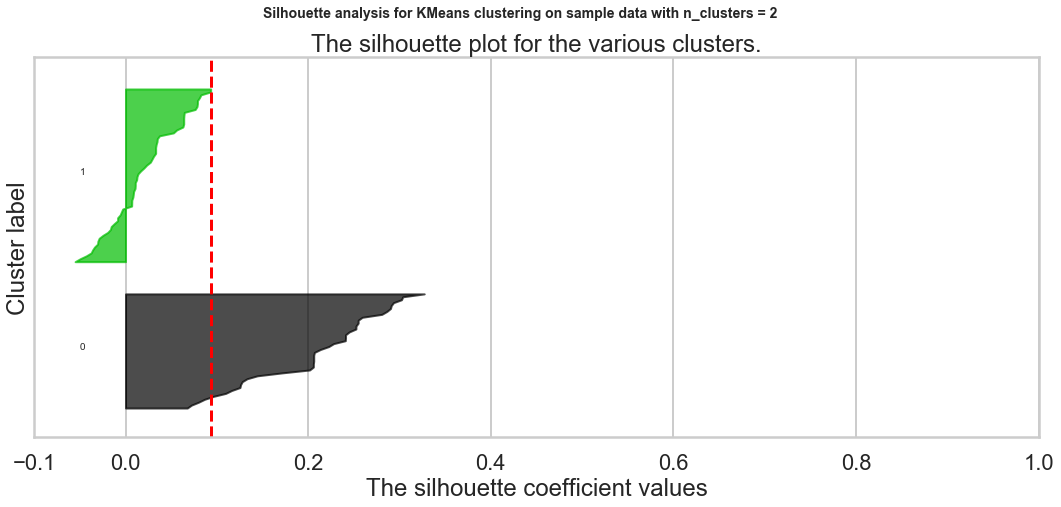

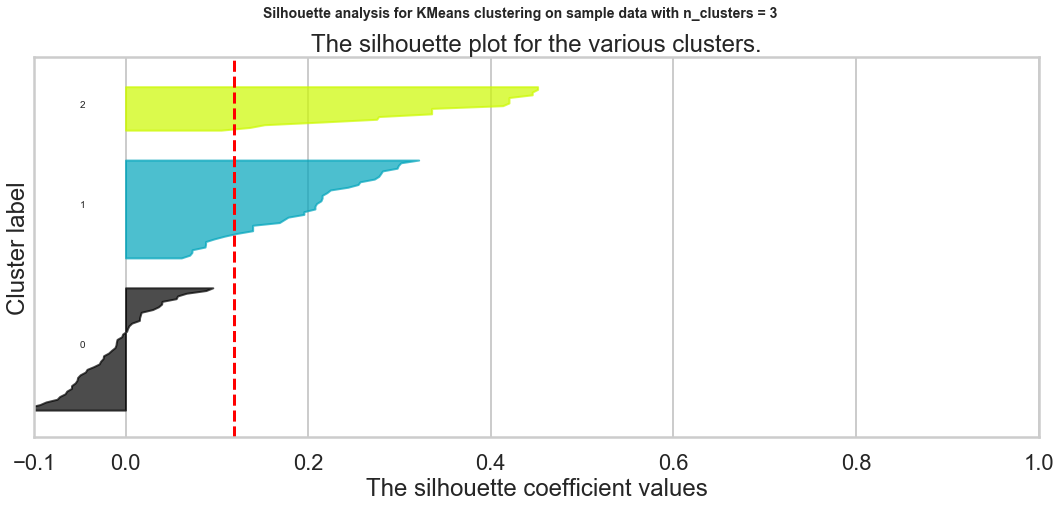

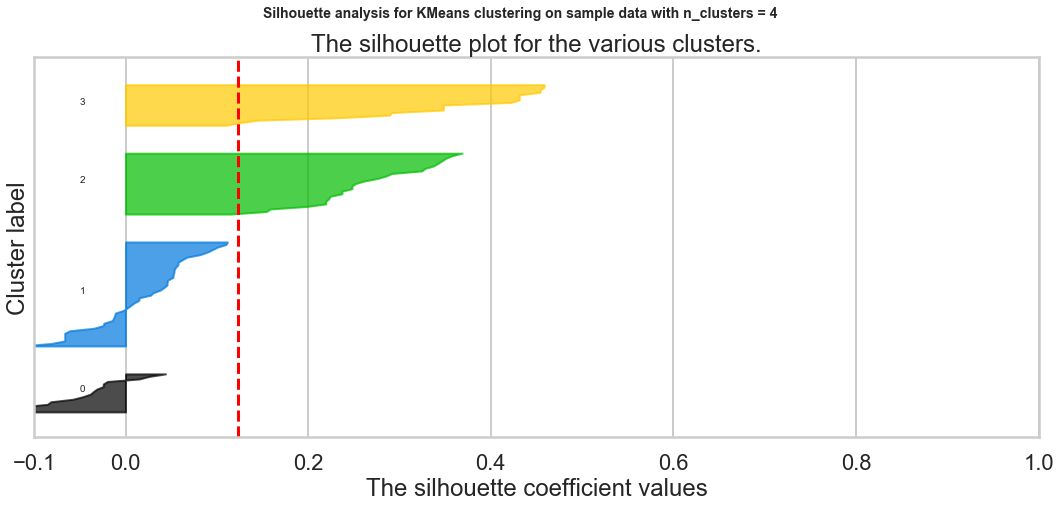

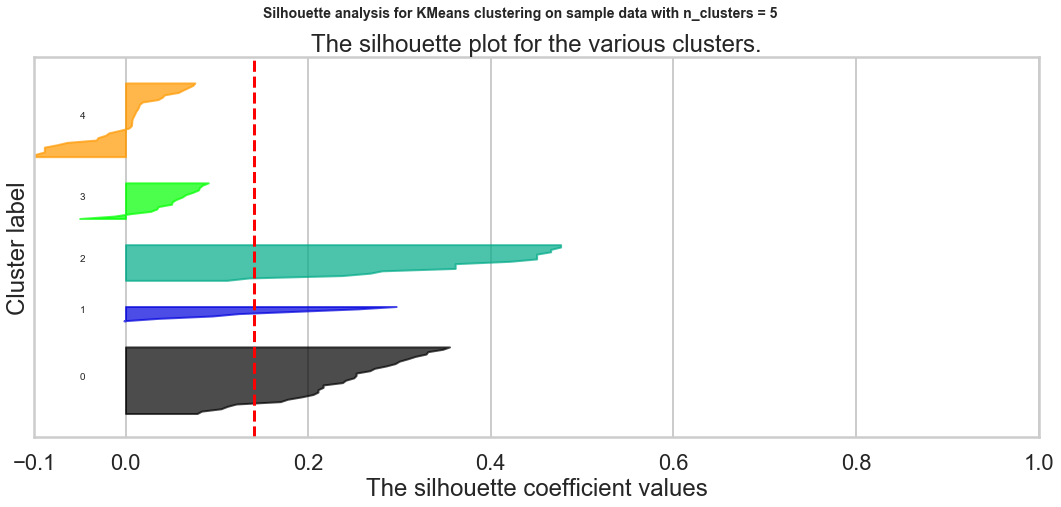

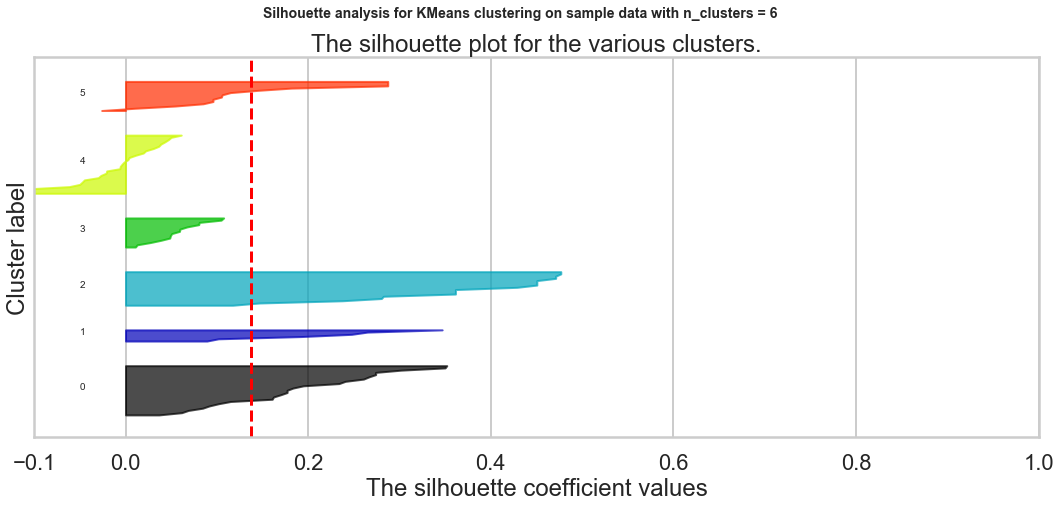

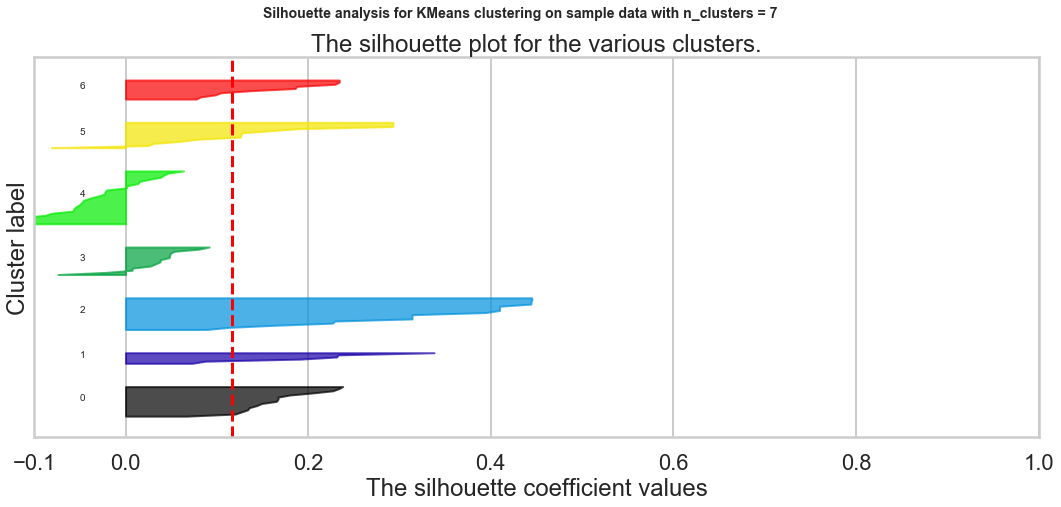

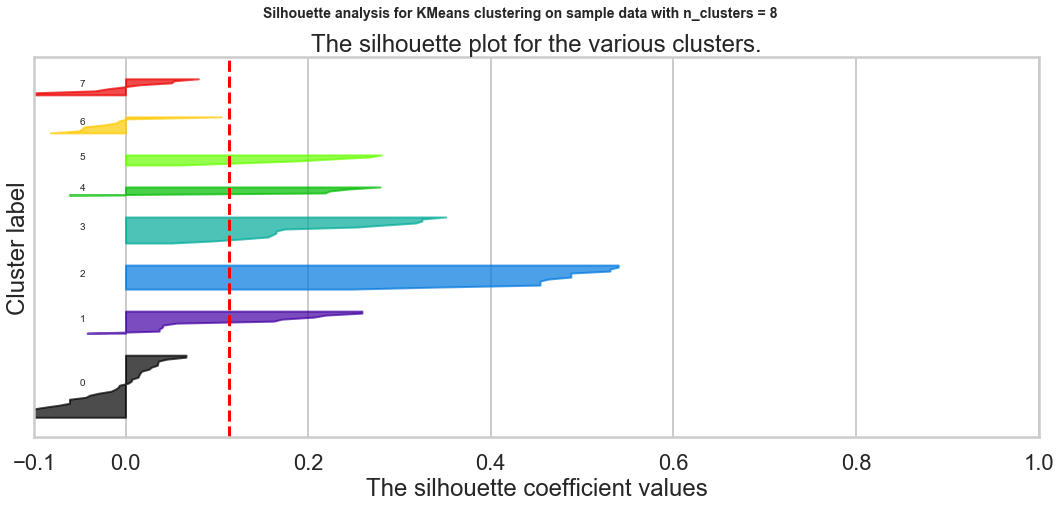

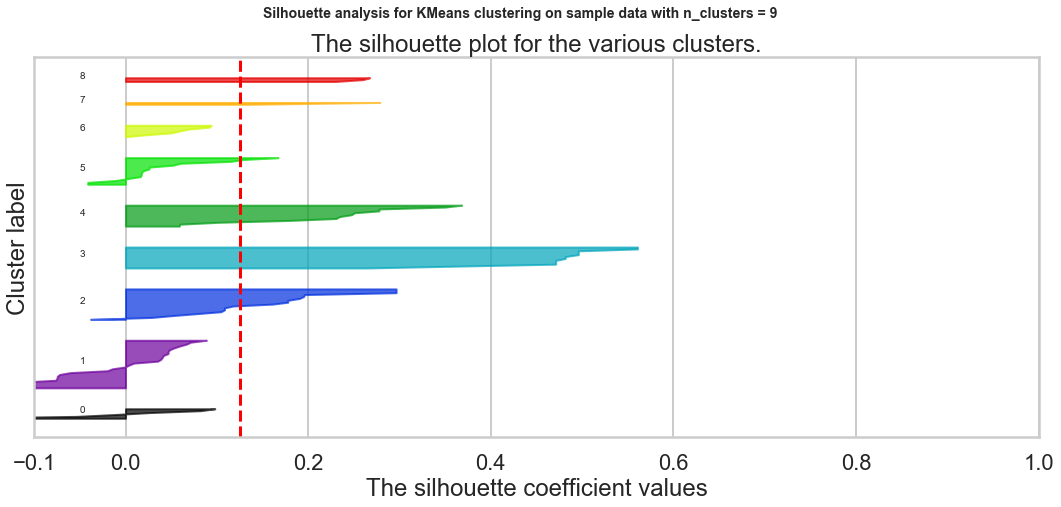

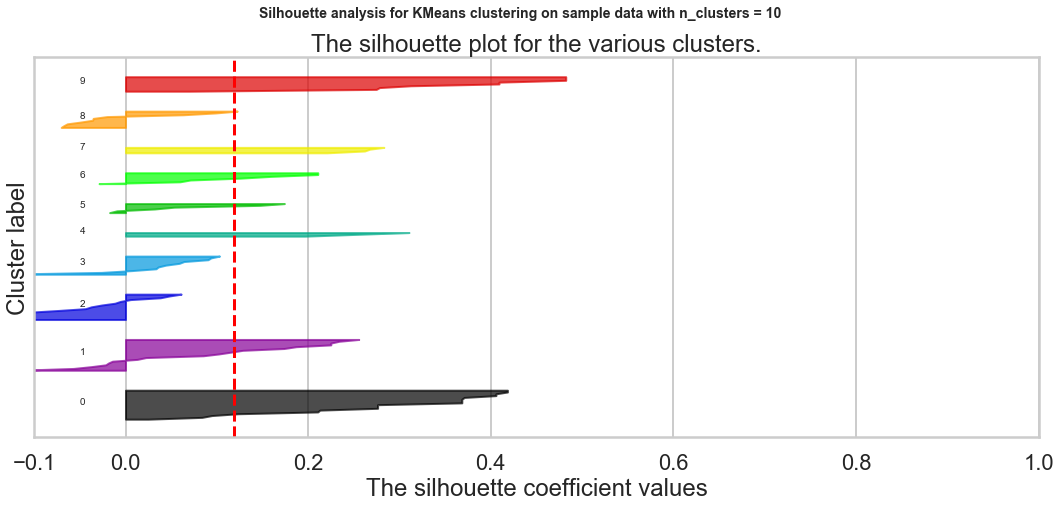

In [17]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
'''X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility'''

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    #silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    #sample_silhouette_values = silhouette_samples(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    '''colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")'''

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

**Exercise**: Compute the average silhouette score for each  K  and plot it. What  K  does the plot suggest we should choose? Does it differ from what we found using the Elbow method?

In [18]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_avgs = []

for n_clusters in range_n_clusters:
 
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    #silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    #sample_silhouette_values = silhouette_samples(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


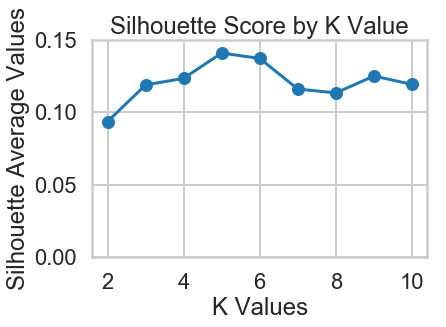

In [19]:
plt.plot(range_n_clusters, silhouette_avgs, 'o-')
plt.xlabel('K Values')
plt.ylabel('Silhouette Average Values')
plt.ylim(0, 0.15)
plt.title("Silhouette Score by K Value")
plt.show()

The plot suggests we should choose K = 5, at least when we look at values between 2 and 10 for K. It differs from the value of 10 that I said I would use when looking at the elbow plot, although I did mention there that the elbow plot was not very informative regarding the best K to use. Therefore, in deciding which value of K to use, I am more inclined to use K = 5 and believe the Silhouette plot, since the Silhouette method seems more appropriate for the data we are using.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [20]:
#your turn

**Exercise**: Use PCA to plot your clusters:

*Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components*

In [21]:
x_cols.shape

(100, 32)

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [23]:
pca.fit(x_cols)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
transformed = pca.transform(x_cols)

In [25]:
transformed.shape

(100, 2)

<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>

In [26]:
model = KMeans(n_clusters=10, random_state=10)
model.fit(x_cols)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [27]:
d = {'customer_name' : cust_by_offer.index, 'cluster_id' : model.labels_, 'x' : transformed[:,0], 'y' : transformed[:,1]}
df = pd.DataFrame(data=d)
df.head()

,customer_name,cluster_id,x,y
0,Adams,1,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,0,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695


*Plot a scatterplot of the `x` vs `y` columns
Color-code points differently based on cluster ID*

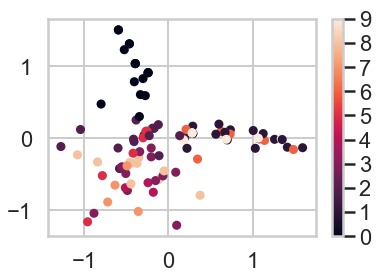

In [28]:
plt.scatter(df.x, df.y, s=50, c=df.cluster_id)
plt.colorbar()
plt.show()

*How do the clusters look?*

Not great, since there are so many with overlap. Points close to each other do tend to be colored the same color though, or at least a close color (see the colorbar). 

*Based on what you see, what seems to be the best value for  K ? Moreover, which method of choosing  K  seems to have produced the optimal result visually?*

It's hard to tell what seems to be the best value for K. Let's look at K = 5:

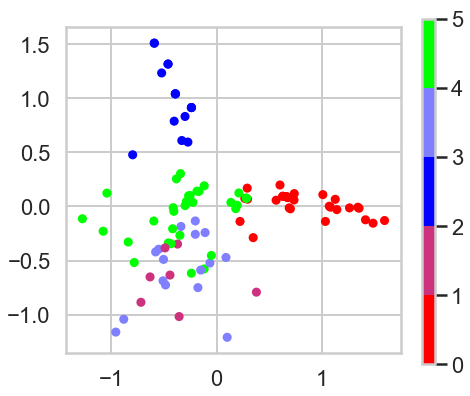

In [29]:
model = KMeans(n_clusters=5, random_state=10)
model.fit(x_cols)

d = {'customer_name' : cust_by_offer.index, 'cluster_id' : model.labels_, 'x' : transformed[:,0], 'y' : transformed[:,1]}
df = pd.DataFrame(data=d)

fig, ax = plt.subplots(1,1, figsize=(6,6))

import matplotlib as mpl
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(len(df.cluster_id.unique()))]
cmaplist[0] = (1, 0, 0, 1.0)
cmaplist[1] = (0.8, 0.2, 0.5, 1.0)
cmaplist[2] = (0, 0, 1, 1.0)
cmaplist[3] = (0.5, 0.5, 1, 1.0)
cmaplist[4] = (0, 1, 0, 1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0,5,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

scat = ax.scatter(df.x, df.y, s=50, c=df.cluster_id, cmap=cmap, norm=norm)

ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

#plt.colorbar()
plt.show()

Looks like a better choice than K = 10.

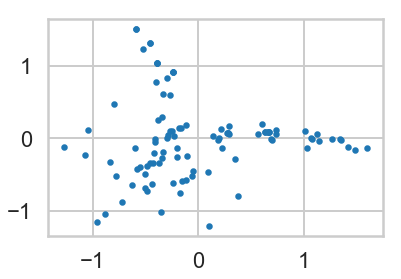

In [30]:
plt.scatter(df.x, df.y, s=20)

By simply looking at a scatterplot of the PCA x and y, the best value of K is not apparent. Therfore, our solution is to plot different values of K and see which produces the best results visually. In our case, we plotted a scatterplot for K=5 and K=10 and K=5 seemed to have produced the better result visually. This confirms my earlier comment that K=5 (arrived at by using the Silhouette method) is probably better than K=10 (arrived at by the elbow method).  

**Exercise**: Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

The approach taken here is as follows:  
The clusters plotted using PCA above represent clusters of **customers**, not of wines. What we fed to PCA was a dataframe 0f 100 customers with information about their purchases on 32 wines. What it returned to us was a dataframe of those same 100 customers, but with their purchase info over 32 products reduced to 2 dimensions. That is, we reduced the problem from a 32 dimensional one to a 2 dimensional one over the100 customers.  

Understanding that is important to interpreting the clusters correctly. Because we now know that the clusters should contain customers with similar purchases. That is, 2 customers who make exactly the same purchases should end up in the same cluster and customers with similar purchases should also be more likely to end up in the same cluster than customers who do not have similar purchases.  

Therefore, to interpret the clusters, I first obtained a list of the customers belonging to that cluster. I then obtained a list of their purchases and looked to see what percentage of the customers in the cluster had purchased each product. I then filtered the list by products that had been purchased by more than half of the customers in the cluster, reasoning that such a product was a main driver of the cluster, and a key method of distinguishing the cluster from other clusters. Finally, I examined the products that remained in their original offer table that shows all the product information, to see if there were similarities in the products. The idea here is that products that remain should be very similar, since we would expect customers to be seperable based on types of wine they like, with a customer being more likely to like a wine that is similar to one he/she already likes.

In [31]:
def cluster(i, perc):
    cluster_custs = df[df.cluster_id == i]['customer_name'].copy() # Get the names of customers in Cluster 0
    cbo = cust_by_offer.loc[cluster_custs].copy() # Get the purchases of customers in cluster 0
    cbo.loc['Total'] = cbo.sum(axis=0) / cbo.shape[0]  # Get the percentage of customers in the customer who bought a product, for every product
    cluster_offers = cbo.loc['Total'] > perc # Get only those products for which over half the customers in the cluster bought it
    return df_offers[cluster_offers.values] # Look at the offer information for those products for which over half the customers bought it
    # Look for similarities

In [32]:
cluster(0, 0.5) # Look at cluster 0

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
6,7,March,Prosecco,6,40,Australia,True
28,29,November,Pinot Grigio,6,87,France,False
29,30,December,Malbec,6,54,France,False


Similarites here are not too strinking. Perhaps the common quality is min quantity being 6 or maybe being from France.

In [33]:
cluster(1, 0.5) 

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
3,4,February,Champagne,72,48,France,True
5,6,March,Prosecco,144,86,Chile,False
21,22,August,Champagne,72,63,France,False
26,27,October,Champagne,72,88,New Zealand,False


This cluster looks like it likes Champagnes that have a minimum quantity of 72.

In [34]:
cluster(2, 0.5) 

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
23,24,September,Pinot Noir,6,34,Italy,False
25,26,October,Pinot Noir,144,83,Australia,False


This cluster looks like it likes Pinot Noir.

In [35]:
cluster(3, 0.5) 

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
30,31,December,Champagne,72,89,France,False


This cluster only has one drink that more than half the people in the cluster bought. Let's dig deeper. First, let's see how many people are in the cluster.

In [36]:
len(df[df.cluster_id == 3]['customer_name'])

16

16 people are in it, so it's not suffering from being too small. Let's now lower the threshould from 50% to 25% to see if we get more drinks:

In [37]:
cluster(3, 0.25)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
21,22,August,Champagne,72,63,France,False
30,31,December,Champagne,72,89,France,False


We get 2 Champagnes from France with a min quantity of 72. So could be another Champagne cluster. Or maybe a 'miscellaneous' cluster?

In [38]:
cluster(4, 0.5) 

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak


Nothing comes up. Let's check cluster size:

In [39]:
len(df[df.cluster_id == 4]['customer_name'])

32

So a big cluster. About a third of the people in the dataset, which explaines why it's hard to find commonalities. Let's lower the threshould.

In [40]:
cluster(4, 0.4)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak


Nothing. Lower further.

In [41]:
cluster(4, 0.3)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
10,11,May,Champagne,72,85,France,False


Lower further.

In [42]:
cluster(4, 0.25)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
10,11,May,Champagne,72,85,France,False
21,22,August,Champagne,72,63,France,False


Champagne again, I guess. Champagne seems to be a popular item, which makes sense.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

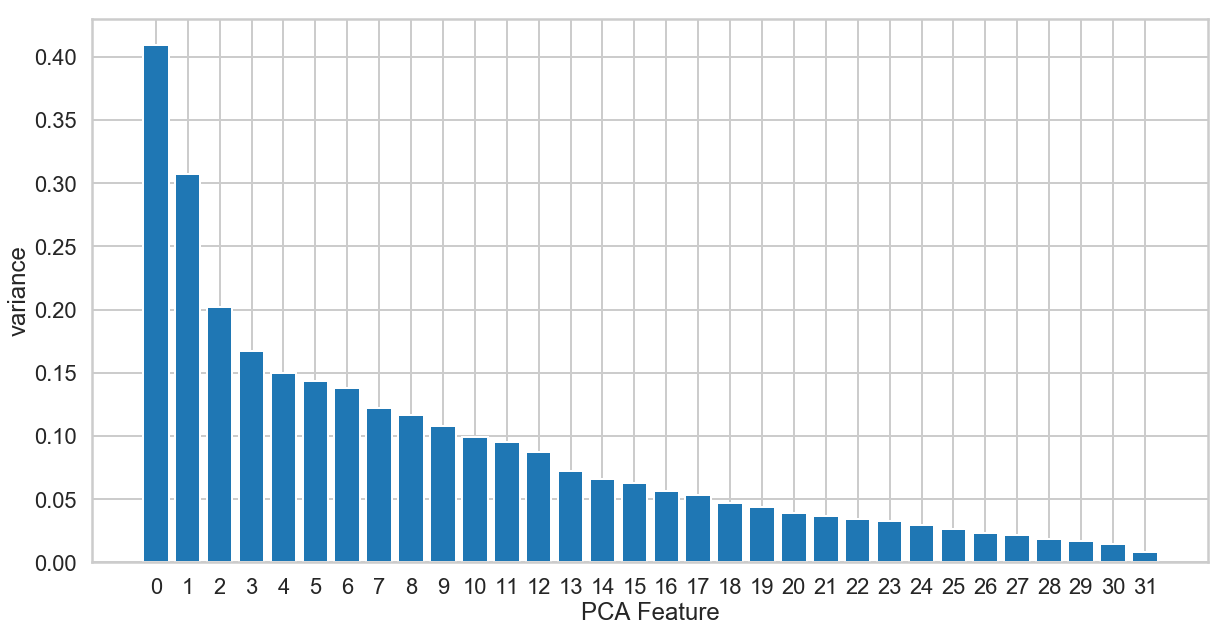

In [43]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
features = range(pca.n_components_)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(features, pca.explained_variance_)
plt.xlabel('PCA Feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()


It seems like the elbow occurs after the first 2 features. An argument can be made to include the 3rd feature, but I think 2 is the optimal number of dimensions.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [44]:
# Your turn

In [45]:
import sklearn.cluster as cluster
import time

Analysis here adopted from: https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

In [46]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths' : 0}

Text(0.5,1,'Points of 100 customers')

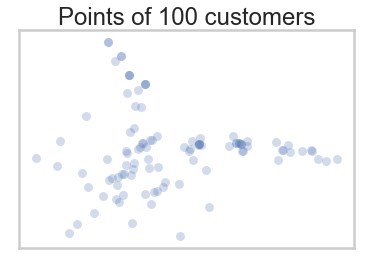

In [47]:
plt.scatter(df.x, df.y, c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.title('Points of 100 customers')

In [48]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(df.x, df.y, c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(0.40, 1.4, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    plt.text(0.40, 1.2, 'Number of clusters: {}'.format(len(np.unique(labels))), fontsize=14)

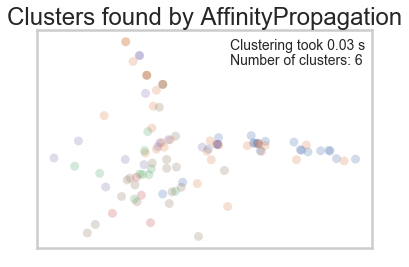

In [49]:
# Affinity Clustering
plot_clusters(x_cols, cluster.AffinityPropagation, (), {'preference':-8.0, 'damping':0.95}) #'preference':-5.0, 'damping':0.95
# Using default parameters

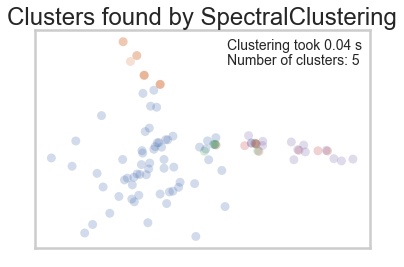

In [50]:
# Spectral Clustering
plot_clusters(x_cols, cluster.SpectralClustering, (), {'n_clusters':5}) #'n_clusters':6


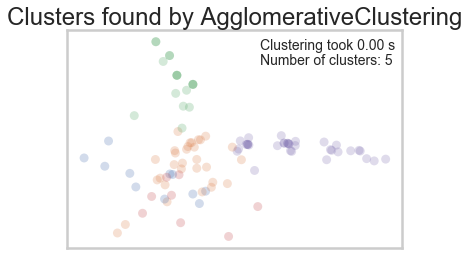

In [51]:
# Agglomerative Clustering
plot_clusters(x_cols, cluster.AgglomerativeClustering, (), {'n_clusters':5}) #'n_clusters':6

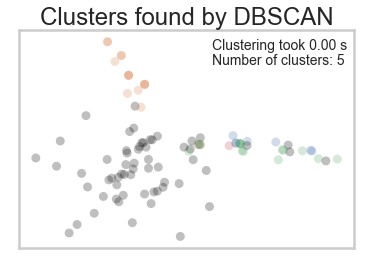

In [52]:
# DBSCAN Clustering
plot_clusters(x_cols, cluster.DBSCAN, (), {'eps': 1.00}) 

The clustering perameters were all tuned to have 5 or 6 clusters based on our earlier findings using K-means that this is a good number of clusters. In terms of performance, it appears (by visual search) that Agglomerative Clustering performs the best on our data, since its clusters avoid overlaping with each other as compared to the other ones. It would seem that this algorithm performs best because there are possible connectivity constraints in our data and non-Euclidean distances should be used with it.

Silhouette Score Method:

In [53]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
algorithms = ['AffinityPropagation', 'SpectralClustering', 'AgglomerativeClustering', 'DBSCAN']
algorithm_silscores = pd.Series(index=algorithms)

In [54]:
# Affinity Propagation

# find the best damping value
dampings = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score = 0
for damping in dampings:
    ap = AffinityPropagation(damping=damping)
    labels = ap.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=42)
    print("For damping =", damping,
         "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_damping = damping

print('Best damping parameter: ', best_damping)
algorithm_silscores.loc['AffinityPropagation'] = best_score
    

For damping = 0.5 The average silhouette_score is : 0.12346523604478911
For damping = 0.6 The average silhouette_score is : 0.12346523604478911
For damping = 0.7 The average silhouette_score is : 0.12346523604478911
For damping = 0.8 The average silhouette_score is : 0.08954554999885996
For damping = 0.9 The average silhouette_score is : 0.08954554999885996
Best damping parameter:  0.5


In [55]:
# Spectral Clustering

# find the best value for n_cluster
range_n_clusters = range(2,11)
best_score = 0
for n_clusters in range_n_clusters:
    sc = SpectralClustering(n_clusters=n_clusters)
    labels = sc.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
         "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

print('Best n_clusters parameter: ', best_n_clusters)
algorithm_silscores.loc['SpectralClustering'] = best_score
    

For n_clusters = 2 The average silhouette_score is : 0.0591405970172056
For n_clusters = 3 The average silhouette_score is : 0.09990591231024579
For n_clusters = 4 The average silhouette_score is : 0.029065698932750638
For n_clusters = 5 The average silhouette_score is : 0.015856768776882108
For n_clusters = 6 The average silhouette_score is : 0.017596416995300394
For n_clusters = 7 The average silhouette_score is : 0.04791935350456086
For n_clusters = 8 The average silhouette_score is : 0.017717861101963942
For n_clusters = 9 The average silhouette_score is : 0.013764325675667094
For n_clusters = 10 The average silhouette_score is : 0.036288719406270424
Best n_clusters parameter:  3


In [56]:
# Agglomerative Clustering

# find the best value for n_cluster
range_n_clusters = range(2,11)
best_score = 0
for n_clusters in range_n_clusters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ac.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
         "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters

print('Best n_clusters parameter: ', best_n_clusters)
algorithm_silscores.loc['AgglomerativeClustering'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.08258017823184984
For n_clusters = 3 The average silhouette_score is : 0.11625878863607858
For n_clusters = 4 The average silhouette_score is : 0.128937578158815
For n_clusters = 5 The average silhouette_score is : 0.14089739970831974
For n_clusters = 6 The average silhouette_score is : 0.1471521720461323
For n_clusters = 7 The average silhouette_score is : 0.15275152751051155
For n_clusters = 8 The average silhouette_score is : 0.15578053718604024
For n_clusters = 9 The average silhouette_score is : 0.12075124131971901
For n_clusters = 10 The average silhouette_score is : 0.09754750747147792
Best n_clusters parameter:  8


In [57]:
# DBSCAN

# find the best value for n_cluster
range_min_samples = [1,2,3]
best_score = 0
for min_samples in range_min_samples:
    db = DBSCAN(min_samples=min_samples)
    labels = db.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For min_samples =", min_samples,
         "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_min_samples = min_samples

print('Best min_samples parameter: ', best_min_samples)
algorithm_silscores.loc['DBSCAN'] = best_score

For min_samples = 1 The average silhouette_score is : 0.19
For min_samples = 2 The average silhouette_score is : -0.021678059481408066
For min_samples = 3 The average silhouette_score is : -0.10663555825496372
Best min_samples parameter:  1


In [58]:
algorithm_silscores

AffinityPropagation        0.123465
SpectralClustering         0.099906
AgglomerativeClustering    0.155781
DBSCAN                     0.190000
dtype: float64

DBSCAN had the highest silhouette score, but neither it nor the other models performed well, since all scores were below 0.25 meaning "no substantial structure has been found". This is not too surprising, since it's hard to define clusters by visually looking at the points.   

Because all the methods performed poorly, it doesn't really make sense to speak of why one method was best.  

In choosing whether we should define Agglomerative Clustering or DBSCAN as the best method, I would choose DBSCAN, since the method by which we found it too be the best was more rigourous nuerically than the method by which we found Agglomerative Clustering to be best (visual inspection). Nevertheless, there is an argument to be made for Agglomerative Clustering, since it's easy to argue that our visual checking should be given high priority.  